# Transfer Learning with Tensorflow
## Notebook Goals
- Describe Transfer Learning & Feature-Extraction transfer learning a bit
- Build & analyze the loss & accuracy of a Transfer-Learning Feature-Extraction Model
- Use the TensorBoard callback to log & visualize model performance
- Have a few resources to leverage while transfer learning: transfer-learning links & tensorboard reference

## Transfer Learning
Transfer learning is taking pre-trained models and using them.  
Transfer learning allows for using "battle-tested" models, without re-invinting the wheel.  

### Feature Extraction
When a pretrained model is used, and _custom data gets used & applied to the model_.  
The "underlying patterns" (_weights_) of the pretrained model get adjusted based on the new data that _you/me use from our dataset(s)_.  
The final/last/top layers are the layers that get over-written in feature extraction transfer learning: if the original model is trained on 100 classes but you & i only need 12 based on our use-case, feature extraction allows us to use the majority of the model (layers & weights) and update the output layer to match our needs.  

### Fine-Tuning
Fine-tuning transfer learning takes the "underlying patterns" (_weights_) and adjust those. Fine-tuning is a more intense over-writing of the original model than feature extraction.  


### Transfer learning "steps"
- check out [pre-trained models on kaggle](https://www.kaggle.com/models?tfhub-redirect=true)
- filter the models by the problem domain in-scope: images, etc.
- _consider / select a tensorflow model_ for this case

### Transfer Learning Resources
[There are a bunch of pre-biult models](https://www.kaggle.com/models?tfhub-redirect=true) available online, built just for tesnorflow. 2 examples:
- [ResNetV2](https://arxiv.org/abs/1603.05027)
- [EfficientNet](https://arxiv.org/abs/1905.11946) (also a google blog post about it [here](https://research.google/blog/efficientnet-improving-accuracy-and-efficiency-through-automl-and-model-scaling/))
- [tensorflow docs on transfer learning](https://www.tensorflow.org/tutorials/images/transfer_learning)


[More models](https://paperswithcode.com/)  



## Imports

In [25]:
# 
# NOTE: tensorflow version 2.15 required:
# 
# dockerfile
# 
# FROM quay.io/jupyter/tensorflow-notebook
# RUN pip uninstall -y tensorflow tf-keras
# RUN pip install tensorflow==2.15 tensorflow_hub
# 

import datetime
import zipfile
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import matplotlib.pyplot as plt
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

# Use Keras 2.
version_fn = getattr(tf.keras, "version", None)
if version_fn and version_fn().startswith("3."):
  print('importing tf_keras')
  import tf_keras as keras
else:
  print('NOT importing tf_keras')
  keras = tf.keras

Notebook last run (end-to-end): 2024-06-24 01:19:29.311954
NOT importing tf_keras


In [6]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [7]:
hub.__version__

'0.16.1'

## Get Data
Based on the food101 dataset, here grapping 10% of the data

In [8]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2024-06-23 22:47:06--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.65.219, 142.251.32.123, 142.251.35.187, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.65.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.2’

10_food_classes_10_ 100%[===================>] 160.74M  18.0MB/s    in 9.3s    

2024-06-23 22:47:16 (17.2 MB/s) - ‘10_food_classes_10_percent.zip.2’ saved [168546183/168546183]



### Inspect Downloaded data

In [9]:
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test

### Create Image-Loaders

In [10]:
# 
# Variables
# 
IMG_OUTPUT_SHAPE = (224, 224)
BATCH_SIZE = 32
MODEL_CLASS_MODE = 'categorical'
data_dir_path = "10_food_classes_10_percent/"
train_dir_path = data_dir_path + "train/"
test_dir_path = data_dir_path + "test/"

train_datagenerator = ImageDataGenerator(rescale=1/255.)
test_datagenerator = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagenerator.flow_from_directory(train_dir_path,
                                               target_size=IMG_OUTPUT_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode=MODEL_CLASS_MODE)

print("Testing images:")
test_data = test_datagenerator.flow_from_directory(test_dir_path,
                                              target_size=IMG_OUTPUT_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode=MODEL_CLASS_MODE)

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


In [11]:
print(f'How many classes in training data: {train_data_10_percent.num_classes}')

How many classes in training data: 10


## Setup Model Callbacks
Tensorflow models use callbacks to interact with the training, during and/or after.  
[Callbacks can be passed to keras methods such as fit(), evaluate(), and predict() in order to hook into the various stages of the model training, evaluation, and inference lifecycle.](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback)

Callback examples:
- [ModelCheckpoint](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint): "_Callback to save the Keras model or model weights at some frequency._"
- [LearningRateScheduler](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler): "_...Learning rate scheduler._"
- [CSVLogger](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/CSVLogger): stream epoch results to a csv file (very interesting!)
- [TensorBoard](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard): enable visualisation for [TensorBoard](https://www.tensorflow.org/tensorboard)

Here, a callback set up for tensorboard logging

In [12]:
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Use A Pre-built Model
Here, we'll play around with two models: resNet and efficientNet.

In [13]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # UPDATED EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

### A model-creator function
Take a url & the number of classes/labels, and return a model that is built on the model-from-url.

In [14]:
def makeModel(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMG_OUTPUT_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

### Create The ResNet Transfer-Learning Ready Model

In [15]:
# 
# Create model
# 
resnet_model = makeModel(resnet_url, num_classes=train_data_10_percent.num_classes)

# 
# Compile
# 
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])


In [16]:
# 
# Fit
# 
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20240624-003501
Epoch 1/5
24/24 [==============================] - 272s 11s/step - loss: 1.9294 - accuracy: 0.3507 - val_loss: 1.2410 - val_accuracy: 0.6024
Epoch 2/5
24/24 [==============================] - 252s 11s/step - loss: 0.9165 - accuracy: 0.7160 - val_loss: 0.8899 - val_accuracy: 0.7080
Epoch 3/5
24/24 [==============================] - 245s 10s/step - loss: 0.6290 - accuracy: 0.8253 - val_loss: 0.7699 - val_accuracy: 0.7452
Epoch 4/5
24/24 [==============================] - 243s 10s/step - loss: 0.4788 - accuracy: 0.8853 - val_loss: 0.7059 - val_accuracy: 0.7684
Epoch 5/5
24/24 [==============================] - 261s 11s/step - loss: 0.3851 - accuracy: 0.9133 - val_loss: 0.6781 - val_accuracy: 0.7784


### Inspect Model
#### Summary

In [20]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


#### Viz Loss & Accuracy Curves

In [23]:
def plot_loss_curves(history):
  chartW = 12
  chartH = 3
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.figure(figsize=(chartW, chartH))
    
  plt.subplot(1, 2, 1)
  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

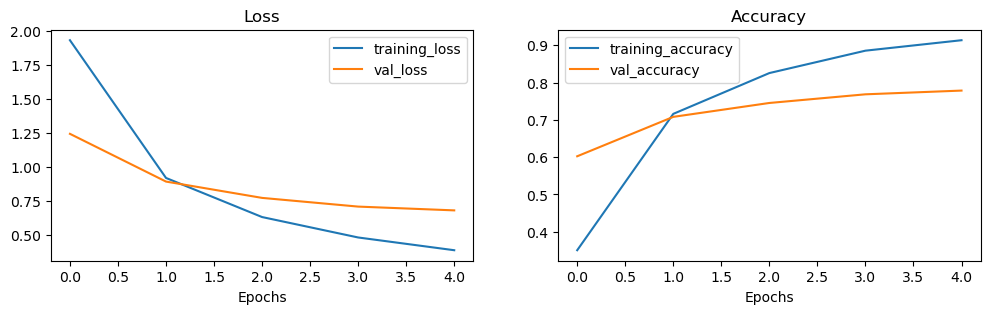

In [24]:
plot_loss_curves(resnet_history)

- the Loss curves MIGHT be indicating that the model is learning the training data better than the testing data: could be overfitting

## Use Pre-Built Model II: EfficientNet

In [27]:
# Create model
efficientnet_model = makeModel(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20240624-012054
Epoch 1/5
24/24 [==============================] - 118s 5s/step - loss: 1.8676 - accuracy: 0.4093 - val_loss: 1.3087 - val_accuracy: 0.7360
Epoch 2/5
24/24 [==============================] - 113s 5s/step - loss: 1.0618 - accuracy: 0.7760 - val_loss: 0.8681 - val_accuracy: 0.8220
Epoch 3/5
24/24 [==============================] - 87s 4s/step - loss: 0.7542 - accuracy: 0.8533 - val_loss: 0.6967 - val_accuracy: 0.8460
Epoch 4/5
24/24 [==============================] - 95s 4s/step - loss: 0.6004 - accuracy: 0.8760 - val_loss: 0.6084 - val_accuracy: 0.8604
Epoch 5/5
24/24 [==============================] - 89s 4s/step - loss: 0.5079 - accuracy: 0.8960 - val_loss: 0.5533 - val_accuracy: 0.8656


### Inspect the Model
#### Summary

In [28]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


#### Viz Loss & Accuracy Curves

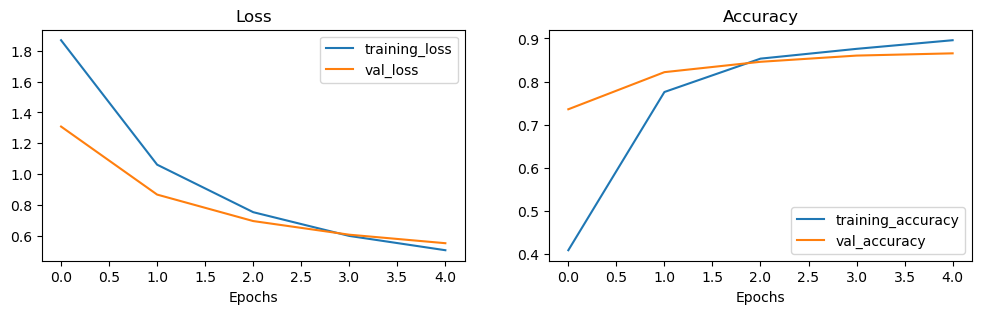

In [29]:
plot_loss_curves(efficientnet_history)

## View analysis in tensorboard
Check out this notebook for ideas on getting tensorboard connected: [here](https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/tensorboard_in_notebooks.ipynb#scrollTo=ko9qeSQHLrEh)